In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import idct
import functions as f
import tests as t

from sys import path


path.append("/home/huseyin/pybrain-master/")

%matplotlib inline

/home/huseyin/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Tests / Data Preparation / Learning

In [2]:
_ = t.run_tests()

flatten_recreate_test:		passed
rescale_max_check_test:		passed
rescale_max_check_test_2:	passed
rescale_data_check_test:	passed
convert_to_z_test:		passed
convert_to_z_test_2:		passed
convert_to_z_test_3:		passed
preprocessing_test:		passed
make_chunks_test:		passed
confusion_matrix_test:		passed


Prepare data

In [3]:
args = {"names": ["slow", "medium", "fast", "veryfast"], "dim":168, "classes": np.array([0, 1, 2, 3])}

begin_cutoff = 200
len_segment = np.genfromtxt("mfccJoints_slow.txt", delimiter = ",").shape[0]
n_mfcc = 13
#print len_segment

mfcc = np.zeros((len_segment, n_mfcc, len(args["names"])))
j_input = np.zeros((len_segment, 2, len(args["names"])))


for i, n  in enumerate(args["names"]):
    name = "mfccJoints_" + n + ".txt"
    temp = np.genfromtxt(name, delimiter = ",")
    mfcc[:, :, i] = f.get_mfcc(temp)[:len_segment, :]
    j_input[:, :, i] = f.get_position(1, temp)[:len_segment, :]
    
mfcc = mfcc[begin_cutoff:, :, :]
j_input = j_input[begin_cutoff:, :, :]

j_input[:, 1, :] = j_input[:, 1, :] - j_input[:, 0, :]

In [4]:
means_m, stds_m, maxes_m, mfcc_sc = f.preprocess(mfcc)
means_j, stds_j, maxes_j, j_input_sc = f.preprocess(j_input)

In [5]:
net = f.learn_mfcc(mfcc_sc[:2000, :, 0], j_input_sc[:2000, :, 0], epochs = 50)

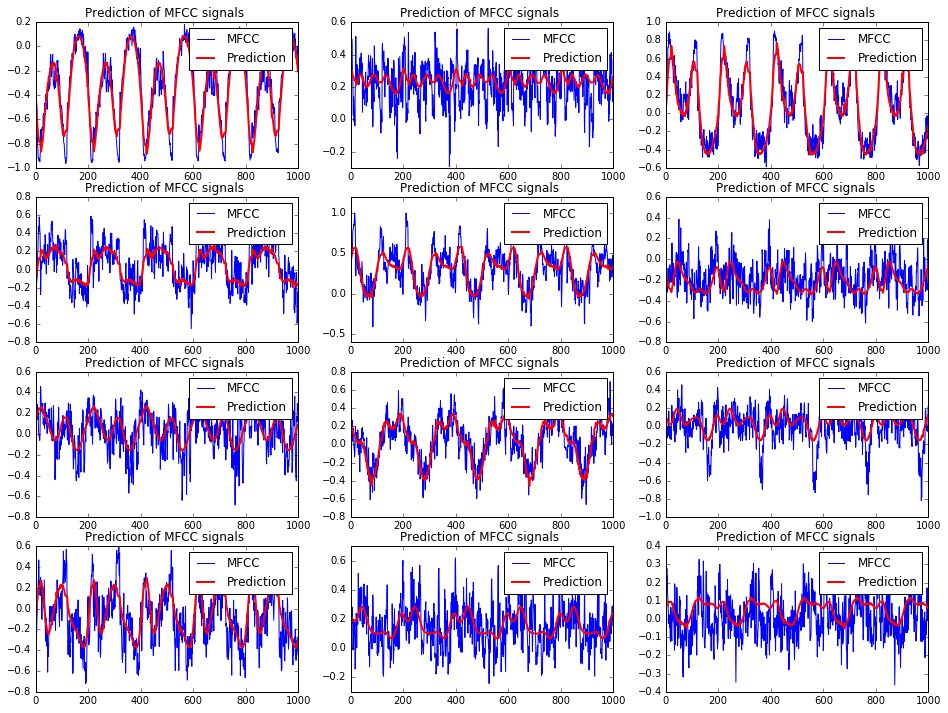

In [6]:
preds = f.predict_mfcc(net, j_input_sc[2000:3000, :, 0])

plt.figure(figsize = (16, 12))

for i in range(12):
    plt.subplot(4,3, i+1)
    plt.plot(mfcc_sc[2000:3000, i, 0], label = "MFCC")
    plt.plot(preds[:, i], color = "red", label = "Prediction", linewidth = 2)
    plt.legend()
    plt.title("Prediction of MFCC signals ")

# Signal subtraction

In [7]:
#means_m, stds_m, maxes_m, preds = means_m[:, 0], stds_m[:, 0], maxes_m[:, 0], preds[:, :, 0]
means_m, stds_m, maxes_m, preds = means_m[:, None], stds_m[:, None], maxes_m[:, None], preds[:, :, None]

rev1 = f.reverse_rescale(maxes_m, preds)
rev2 = f.unconvert_from_z(means_m, stds_m, rev1)

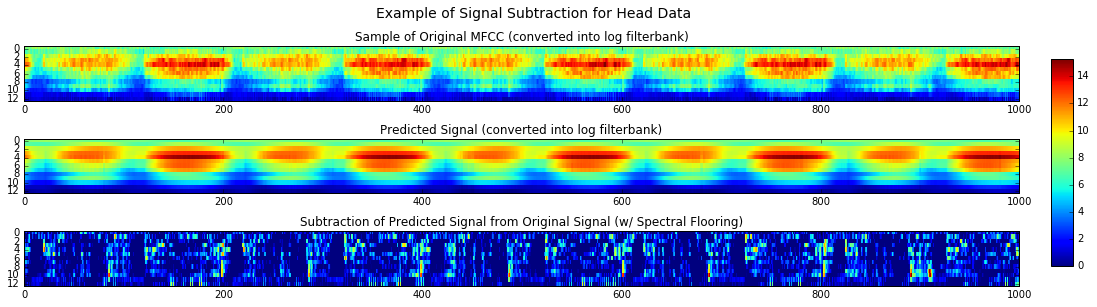

In [8]:
plt.figure(figsize = (15, 4))

plt.subplot(311)
plt.imshow(idct(mfcc[2000:3000, :, 0].squeeze()).T, aspect="auto", interpolation = "nearest")
plt.title("Sample of Original MFCC (converted into log filterbank)")

plt.subplot(312)
plt.imshow(idct(rev2.squeeze()).T, aspect="auto", interpolation = "nearest")
plt.title("Predicted Signal (converted into log filterbank)")

plt.subplot(313)
plt.tight_layout()
ex_sub_signal = idct(mfcc[2000:3000, :, 0].squeeze()).T - idct(rev2.squeeze()).T
ex_sub_signal[ex_sub_signal < 0] *= 0.00001
plt.imshow(ex_sub_signal, aspect="auto", interpolation = "nearest")
plt.title("Subtraction of Predicted Signal from Original Signal (w/ Spectral Flooring)")


plt.subplots_adjust(right=0.95)
cbar_ax = plt.axes([0.98, 0.15, 0.02, 0.72])
plt.colorbar(cax=cbar_ax)
plt.suptitle("Example of Signal Subtraction for Head Data",y = 1.05, fontsize = 14)

# Classification / Crossvalidation

In [9]:
n_folds = 5
n_cls = 4
nets = []

mfcc_cval_train, mfcc_cval_test = f.make_chunks(mfcc_sc[6000:7000, :, :], n_folds)
j_input_cval_train, j_input_cval_test= f.make_chunks(j_input_sc[6000:7000, :, :], n_folds)
#preds_cval = np.zeros(np.concatenate((mfcc_cval_test.shape[:-1], [n_cls], [n_folds])))
dists = np.zeros((mfcc_cval_test.shape[0], n_cls, n_cls, n_folds))
conf_mats = np.zeros((n_cls, n_cls, n_folds))

In [ ]:
for i in range(n_folds):
    print "Fold " + str(i+1)
    nets_fold = []
    for j in range(n_cls):
        nets_fold.append(f.learn_mfcc(mfcc_cval_train[:, :, j, i],\
                                      j_input_cval_train[:, :, j, i], epochs = 50))
        for k in range(n_cls):
            preds_cval_temp = f.predict_mfcc(nets_fold[j], j_input_cval_test[:, :, k, i])
            dists[:, j, k, i] = np.linalg.norm(mfcc_cval_test[:, :, k, i] - preds_cval_temp, axis = 1)
            
        preds_class = np.argmin(dists[:, :, :, i], axis = 1)
    conf_mats[:, :, i] = f.calculate_confusion_matrix(preds_class, np.arange(4))
    nets.append(nets_fold)

avg_conf_mat = np.average(conf_mats, axis = 2)

In [12]:
print "Averaged confusion matrix:\n", avg_conf_mat

Averaged confusion matrix:
[[ 0.934  0.146  0.06   0.022]
 [ 0.046  0.73   0.136  0.094]
 [ 0.008  0.022  0.744  0.126]
 [ 0.01   0.1    0.06   0.756]]
